<a href="https://colab.research.google.com/github/pipeton8/6.864-advanced-nlp/blob/main/Assignments/Assignment%203/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 - Advanced NLP

(c) Felipe del Canto, October 2021

_Built upon scaffolding code provided by the instructors_
***
***

# Part 0 (Execute first!)

In [1]:
from IPython.display import clear_output

!rm -rf hw3
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%203/lab_util.py -P hw3
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%203/reviews.csv -P hw3
!wget https://github.com/pipeton8/6.864-advanced-nlp/raw/main/Assignments/Assignment%203/trees.zip -P hw3
!unzip -o hw3/trees.zip -d hw3/trees
!rm -r __MACOSX hw3/trees/__MACOSX hw3/trees.zip

clear_output()

In [ ]:
import sys
sys.path.insert(1, '/content/hw3')
sys.path.insert(1, '/content/hw3/trees/')

import csv
import random
import itertools         as it
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

import sklearn.linear_model

import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F

from tqdm.auto           import tqdm
from torch               import cuda
from torch.nn.functional import log_softmax
from scipy.special       import logsumexp 
from span_tree           import *

import lab_util

# Part 1: Hidden Markov Models

In Part 1 of this homework, you'll use the Baum--Welch algorithm to learn _categorical_ representations of words in your vocabulary. This uses the same dataset and lab_util as in HW 2. 

## Load data

In [3]:
# Set random seed
np.random.seed(0)

data = []
n_positive = 0
n_disp = 0 
with open("/content/hw3/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue
      n_positive += 1
    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue
    n_disp += 1
    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")
np.random.shuffle(data)
reviews, labels = zip(*data)
train_reviews = reviews[:3000]
train_labels = labels[:3000]
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

## Forward and Backward algorithm

Next, implement the forward--backward algorithm for HMMs like we saw in class.

**IMPORTANT NOTE**: if you directly multiply probabilities as shown on the class slides, you'll get underflow errors. You'll want to work in the log domain (remember that `log(ab) = log(a) + log(b)`, `log(exp(a) + exp(b)) = logaddexp(a, b)`). You should use the first hint whenever you want to multiply/divide numbers by adding them in log space instead, and you should use the second hint whenever you want to add numbers that are already in or could be converted to log space. In general, we recommend either `np.logaddexp` or `scipy.special.logsumexp` as safe ways to compute the necessary quantities.

In [4]:
# HMM model
class HMM(object):
    def __init__(self, num_states, num_words, random_state=0):
      # Initialize random generator using provided seed
      rng = np.random.default_rng(random_state)

      # Initialize properties
      self.num_states = num_states
      self.num_words = num_words

      self.states = range(num_states)
      self.symbols = range(num_words)

      # Initialize matrix of transition probabilities p(j|i) from uniform
      # distribution. The second transformation ensures the sum of rows equals 1
      self.A = rng.uniform(size=(num_states, num_states))
      self.A = self.A/self.A.sum(axis=1,keepdims=True)

      # Initialize matrix of emission probabilities p(o|i) from uniform
      # distribution. The second transformation ensures the sum of rows equals 1
      self.B = rng.uniform(size=(num_states, num_words))
      self.B = self.B/self.B.sum(axis=1,keepdims=True)

      # Initialize vector of initial distribution of states from uniform
      # distribution. The second transformation ensures the sum of pi equals 1
      self.pi = rng.uniform(size=(num_states,))
      self.pi = self.pi/self.pi.sum()

    def generate(self, n, return_states=False, random_state=0):
        """This function randomly samples the HMM to generate a sequence of
        length n.
        """

        # Set random seed for reproducibility
        rng = np.random.default_rng(random_state)

        # Initialize the first state
        state = rng.choice(self.states, p=self.pi)

        # Initialize sequence and state lists
        sequence = []
        states = [state]
        
        # Sample
        for i in range(n):
            # Get the emission probs for this state
            b = self.B[state, :]

            # Emit a word
            word = rng.choice(self.symbols, p=b)
            sequence.append(word)

            # Get the transition probs for this state
            a = self.A[state, :]

            # Update the state
            state = rng.choice(self.states, p=a)
            states.append(state)
        
        if return_states:
          return sequence, states
        
        return sequence

    def forward(self, obs):
        """
        Runs the forward algorithm. This function returns a 
        `len(obs) x  num_states` matrix where the (t, i)th entry contains 
        log p(obs[:t], hidden_state_t = i)
        """

        # Initialize alpha matrix of forward algorithm
        alpha = np.zeros((len(obs), self.num_states))
        
        # Fill first row
        alpha[0,:] = np.log(self.pi) + np.log(self.B[:,obs[0]])

        # Fill the rest of the rows
        for t in range(1,alpha.shape[0]):
            alpha[t,:] = np.log(self.B[:,obs[t]]) + logsumexp(alpha[t-1,:] + np.log(self.A.T), axis=1)
            
        return alpha

    def backward(self, obs):
        """
        Runs the backward algorithm. This function returns a
        `len(obs) x num_states` matrix where the (t, i)th entry contains
        log p(obs[t+1:] | hidden_state_t = i)
        """

        # Initialize beta matrix of backward algorithm. With this, first row
        # is already filled
        beta = np.zeros((len(obs), self.num_states))

        # Fill the remaining rows
        for t in [len(obs)-1-i for i in range(1,len(obs))]:
          beta[t,:] = logsumexp(np.log(self.A) + np.log(self.B[:,obs[t+1]]) 
                                  + beta[t+1,:], axis=1)

        return beta
        
    def forward_backward(self, obs):
        """
        Computes forward-backward scores

        - logprob is the total log-probability of the sequence obs (marginalizing
        over hidden states).

        - gamma is a matrix of size `len(obs) x num_states`. It contains the
        marginal probability of being in state i at time t

        - xi is a tensor of size `len(obs) - 1 x num_states x num_states`. It contains
        the marginal probability of transitioning from i to j at t.

        """

        # Run forward and backward algorithms
        alpha, beta = self.forward(obs), self.backward(obs)

        # Compute logprob marginalizing p(O) over hidden states at t = len(obs)
        logprob = logsumexp(alpha[-1,:])

        # Compute log(gamma), normalize and compute gamma
        log_gamma = alpha + beta - logprob
        log_gamma = log_gamma - logsumexp(log_gamma, axis=1, keepdims=True)
        gamma = np.exp(log_gamma)

        # Compute xi
        xi = np.zeros((len(obs)-1, self.num_states, self.num_states))

        for t in range(len(obs)-1):
          # Compute log of xi_t
          log_xi_t = (np.tile(alpha[t,:].reshape(-1,1), (1,self.num_states)) 
                                + np.log(self.A) 
                                + np.tile(np.log(self.B[:,obs[t+1]]).reshape(1,-1), (self.num_states,1))
                                + np.tile(beta[t+1,:].reshape(1,-1), (self.num_states,1))
                     ) - logprob        
          
          # Normalize
          log_xi_t = log_xi_t - logsumexp(log_xi_t)

          # Insert row into matrix
          xi[t, :, :] = np.exp(log_xi_t) 

        return logprob, xi, gamma

    def learn_unsupervised(self, corpus, num_iters=10, verbose = True, print_every=10):
        """Run the Baum Welch EM algorithm
        
        corpus: the data to learn from
        num_iters: the number of iterations to run the algorithm
        print_every: how often to print the log-likelihood while the model is
        updating its parameters.
        """

        for i_iter in tqdm(range(num_iters)):
          """
          expected_si: a vector of size (num_states,) where the i-th entry is
          the expected number of times a sentence is transitioning from state 
          i to some other state. Be careful about which states this includes!

          expected_sij: an array of size (num_states, num_states) where the
          (i,j)-th entry represents the expected number of state transitions
          between state i and state j.

          expected_sjwk: an array of size (num_states, num_words) where the 
          (j,k)-th entry represents the expected number of times the word w_k 
          appears when at state j.

          expected_q1: a vector of size (num_states,) where the i-th entry is 
          the expected number of times state i is the first state.

          total_logprob: The log of the probability of the corpus being
          generated with the current parameters of the HMM.
          """

          # Initialize Baum-Welch estimates
          expected_si   = np.zeros((self.num_states,))
          expected_sij  = np.zeros((self.num_states, self.num_states))
          expected_sjwk = np.zeros((self.num_states, self.num_words))
          expected_q1   = np.zeros((self.num_states,))
          total_logprob = 0
          
          for review in corpus:
            review = np.array(review)

            # Run forward-backward algorithm
            logprob, xi, gamma = self.forward_backward(review)

            # Compute E(s_i -> s_*)
            expected_si += np.sum(gamma[:-1,:], axis=0)

            # Compute E(s_i -> s_j)
            expected_sij += np.sum(xi[:-1,:,:], axis=0)

            # Compute E(s_j, w_k)
              ## Method 1
            check_word_matrix = np.tile(np.arange(self.num_words).reshape(-1,1), (1,len(review)))
            review_mask = (review.reshape(1,-1) == check_word_matrix).astype(float)

            expected_sjwk += gamma.T @ review_mask.T

              ## Method 2 (deprecated)
            # for word in range(self.num_words):
            #   mask = (review == word).reshape(-1,1)

            #   expected_sjwk[:,word] += np.sum(np.where(mask, gamma, 0), axis = 0)

            # Compute E(q_1 = s_i)
            expected_q1 += gamma[0,:]

            # Compute total_logprob
            total_logprob += logprob

          if verbose and i_iter % print_every == 0:
            print("log-likelihood: ", total_logprob)

          # M step, recompute model parameters
          A_new = np.log(expected_sij) - np.log(expected_si[:, np.newaxis])
          B_new = np.log(expected_sjwk) -  np.log(expected_sjwk.sum(axis = 1, keepdims=True))
          pi_new = expected_q1

          # Update parameters
          self.A = np.exp(A_new - logsumexp(A_new, axis=1, keepdims=True))
          self.B = np.exp(B_new - logsumexp(B_new, axis=1, keepdims=True))
          self.pi = pi_new/np.sum(pi_new)

## Test Cases

The following are test cases that are meant to help you debug your code. The code involves six test suites - an initialization test, a forward test, a backward test, a forward_backward test, a baum_welch_update test, and a final end_to_end test.

### Test functions

In [5]:
def init_test():

    num_states = np.random.randint(100)
    num_words = np.random.randint(100)
    model = HMM(num_states, num_words)

    assert model.A.shape == (num_states, num_states)
    assert model.B.shape == (num_states, num_words)
    assert model.pi.shape == (num_states, )

    assert np.linalg.norm(np.sum(model.A, axis=1) - np.ones(num_states)) < 1e-10
    assert np.linalg.norm(np.sum(model.B, axis=1) - np.ones(num_states)) < 1e-10
    assert np.linalg.norm(np.sum(model.pi) - 1) < 1e-10

    print("Passed init test!")

def forward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    alpha = model.forward(obs)

    true_alpha = np.array([[-2.96913, -3.43382],
                          [ -4.66005, -9.19418],
                          [ -7.35001, -7.89695],
                          [ -9.65069, -9.95363],
                          [-11.25815, -14.27392],
                          [-18.14079, -14.4781 ],
                          [-16.89275, -18.62696],
                          [-19.45549, -20.17289],
                          [-21.53772, -23.283  ],
                          [-23.4927, -26.69119],
                          [-25.84891, -26.73817],
                          [-28.12237, -29.92402]])

    diff = np.linalg.norm(np.sum(np.round(alpha,5) - true_alpha, axis=1))

    if diff < 1e-5:
      print("Passed forward test!")

    else:
      print("The result of the forward function should be", true_alpha)
      print("Your value of alpha is:", np.round(alpha, 5))
      print("diff = ", diff)

def backward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    beta = model.backward(obs)

    true_beta = np.array([[-25.42937, -25.58918], 
                          [-23.32164, -23.19959],
                          [-21.11007, -21.02033],
                          [-18.82215, -18.94381],
                          [-16.78523, -16.33951],
                          [-13.42847, -13.51924],
                          [-11.24815, -11.19161],
                          [ -8.88679,  -8.96441],
                          [ -6.57374,  -6.70985],
                          [ -4.51873,  -4.47419],
                          [ -2.44529,  -2.51463],
                          [  0, 0]])

    diff = np.linalg.norm(np.sum(np.round(beta,5) - true_beta, axis=1))
    if diff < 1e-5:
      print("Passed backward test!")

    else:
      print("The result of the backward function should be", true_beta)
      print("Your value of beta is:", np.round(beta, 5))
      print("diff = ", diff)

def forward_backward_test():
    model = HMM(2, 10)
    model.A = np.array([[0.79034887, 0.20965113],
                        [0.66824331, 0.33175669]])
    model.B = np.array([[0.08511814, 0.06627238, 0.08487461, 0.15607959, 0.00124582, 0.12984083, 0.11164849, 0.11591902, 0.15232716, 0.09667395],
                        [0.18425462, 0.14326559, 0.14026994, 0.0215989,  0.17687124, 0.04681278, 0.05857451, 0.17451212, 0.00473382, 0.04910648]])
    model.pi = np.array([0.77480039, 0.22519961])
    obs = [1, 8, 0, 0, 3, 4, 5, 2, 6, 3, 7, 9]
    logprob, xi, gamma = model.forward_backward(obs)

    true_logprob = -27.96963

    true_xi = np.array([[[0.64523, 0.00601],
                        [0.34278, 0.00598]],
                        [[0.60684, 0.38117],
                        [0.00551, 0.00648]],
                        [[0.40595, 0.2064 ],
                        [0.19863, 0.18902]],
                        [[0.5718,  0.03278],
                        [0.35711, 0.03831]],
                        [[0.02625, 0.90266],
                        [0.00109, 0.07   ]],
                        [[0.02482, 0.00251],
                        [0.81777, 0.15489]],
                        [[0.59943, 0.24316],
                        [0.08947, 0.06793]],
                        [[0.6143,  0.07461],
                        [0.25347, 0.05762]],
                        [[0.8357,  0.03207],
                        [0.12337, 0.00886]],
                        [[0.69872, 0.26034],
                        [0.02412, 0.01682]],
                        [[0.63701, 0.08583],
                        [0.22134, 0.05582]]])
    
    true_gamma = np.array([[0.65124, 0.34876],
                          [0.98802, 0.01198],
                          [0.61235, 0.38765],
                          [0.60458, 0.39542],
                          [0.92891, 0.07109],
                          [0.02733, 0.97267],
                          [0.8426,  0.1574 ],
                          [0.68891, 0.31109],
                          [0.86777, 0.13223],
                          [0.95906, 0.04094],
                          [0.72284, 0.27716],
                          [0.85835, 0.14165]])

    diff_log = np.abs(np.exp(logprob) - np.exp(true_logprob))
    diff_xi  = np.linalg.norm(np.round(xi,5) - true_xi)
    diff_gamma = np.linalg.norm(np.round(gamma,5) - true_gamma)

    if np.max([diff_log, diff_xi, diff_gamma]) < 1e-10:
      print("Passed forward-backward test!")

    else:
      print("The value of logprob should be:", true_logprob)
      print("Your value of logprob is:", np.round(logprob, 5))
      print("Diff = ", diff_log)
      print("")

      print("The value of xi should be:", true_xi)
      print("Your value of xi is:", np.round(xi, 5))
      print("Diff = ", diff_xi)
      print("")

      print("The value of gamma should be:", true_gamma)
      print("Your value of gamma is:", np.round(gamma, 5))
      print("Diff = ", diff_gamma)

def baum_welch_update_test(num_iters=200):
    model = HMM(4, 10)
    
    model.A = np.array([[0.05263151, 0.62161178, 0.06683182, 0.25892489],
                        [0.26993274, 0.13114741, 0.32305468, 0.27586517],
                        [0.2951958,  0.14576492, 0.22474111, 0.33429817],
                        [0.29586018, 0.26065884, 0.1977772,  0.24570378]])
    
    model.B = np.array([[0.01800425, 0.09767131, 0.17824799, 0.12586453, 0.19514548, 0.05433139, 0.01995667, 0.12985343, 0.01884263, 0.16208232],
                        [0.04512782, 0.09469685, 0.1426164,  0.13851362, 0.08717793, 0.17152532, 0.08746939, 0.04900339, 0.05315859, 0.13071069],
                        [0.11055806, 0.10592473, 0.0051817,  0.07721441, 0.21761783, 0.20323146, 0.18881598, 0.00584989, 0.00682669, 0.07877924],
                        [0.08711377, 0.16703645, 0.0706214,  0.05297571, 0.10486868, 0.16794587, 0.13562053, 0.15729142, 0.03345308, 0.02307309]])
    
    model.pi = np.array([0.21186864, 0.27156561, 0.37188523, 0.14468051])
    
    corpus = np.array([[7,3,2,5,0,3,2,9,4,2], [7,3,2,4,2,8,7,5,0,8], [7,3,2,3,1,7,3,8,6,7], [7,3,2,6,4,4,3,4,0,0]])

    model.learn_unsupervised(corpus, num_iters)

    true_A = np.array([[0, 1, 0, 0], 
                      [0.14122, 0, 0.27099, 0.58779], 
                      [0.20671, 0, 0, 0.79329], 
                      [0, 0.90909, 0.09091, 0]])

    true_B = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                      [0.0625, 0, 0, 0.5, 0, 0.125, 0.125, 0, 0.125, 0.0625],
                      [0, 0.20671, 0, 0, 0.79329, 0, 0, 0, 0, 0],
                      [0.24667, 0, 0.57555, 0, 0.09556, 0, 0, 0, 0.08222, 0]])

    true_pi = np.array([1, 0, 0, 0])

    diff_A = np.linalg.norm(np.sum(np.round(model.A,5) - true_A, axis=1))
    diff_B = np.linalg.norm(np.sum(np.round(model.B,5) - true_B, axis=1))
    diff_pi = np.linalg.norm(model.pi - true_pi)

    if np.max([diff_A, diff_B, diff_pi]) < 1e-10:
      print("Passed Baum-Welch test!")
    
    else:
      print("hmm.A should be", true_A)
      print("Your implementation has hmm.A to be", np.round(model.A, 5))
      print("Diff = ", diff_A)
      print("")

      print("hmm.B should be", true_B)
      print("Your implementation has hmm.B to be", np.round(model.B, 5))
      print("Diff = ", diff_B)
      print("")

      print("hmm.pi should be", true_pi)
      print("Your implementation has hmm.pi to be", np.round(model.pi, 5))
      print("Diff = ", diff_pi)
      print("")

def end_to_end_test():
    # Test Case 1
    corpus = np.array([[0,3,0,3,0,3,0,3,0,3,0,3], 
                       [0,2,0,2,0,2,0,2,0,2,0,2,0], 
                       [1,2,1,2,1,2,1,2,1,2,1,2],
                       [1,3,1,3,1,3,1,3,1,3]])
    
    hmm = HMM(num_states=2,num_words=4)
    hmm.learn_unsupervised(corpus, 10)

    true_A = np.array([[0, 1], [1, 0]])
    true_B_1 = np.array([[0, 0, 0.5, 0.5], [0.5, 0.5, 0, 0]])
    true_B_2 = np.array([[0.5, 0.5, 0, 0], [0, 0, 0.5, 0.5]])

    diff_A = np.linalg.norm(np.round(hmm.A,5) - true_A)
    diff_B_1 = np.linalg.norm(np.round(hmm.B,5) - true_B_1)
    diff_B_2 = np.linalg.norm(np.round(hmm.B,5) - true_B_2)

    if diff_A < 1e-10 and (diff_B_1 < 1e-10 or diff_B_2 < 1e-10):
      print("End-to-end test #1 passed!")
    
    else:
      print("After this test case, hmm.A should be approximately,", true_A)
      print("This is your current value of hmm.A: ", np.round(hmm.A, 5))
      print("Diff = ", diff_A)
      print("")

      print("After this test case, hmm.B should either be approximately,", true_B_1 , " or it should be ", true_B_2)
      print("This is your current value of hmm.B: ", np.round(hmm.B, 5))
      print("Diff option 1 = ", diff_B_1)
      print("Diff option 2 = ", diff_B_2)
      print("")

    # Test Case 2
    corpus = np.array([[0,0,0,0,0,0,0,0,0,0], 
                       [1,1,1,1,1,1,1,1,1,1], 
                       [2,2,2,2,2,2,2,2,2,2]])
    hmm = HMM(num_states=3, num_words=3)
    hmm.learn_unsupervised(corpus, 100)

    true_A = np.eye(3)

    diff_A = np.linalg.norm(np.round(hmm.A,5) - true_A)

    if diff_A < 1e-10:
      print("End-to-end test #1 passed for matrix A!")

    else:
      print("After this test case, hmm.A should be approximately,", true_A)
      print("This is your current value of hmm.A: ", np.round(hmm.A, 5))
      print("Diff = ", diff_A)
      print("")
    
    print("After this test case, hmm.B should be some 3 by 3 permutation matrix")
    print("This is your current value of hmm.B: ", np.round(hmm.B, 5))

### Run tests

In [6]:
init_test()
forward_test()
backward_test()
forward_backward_test()
baum_welch_update_test()
end_to_end_test()

# """
# Note: The end_to_end_test is not as robust due to it using random starts. Try
# running the test case a few times to see if you get a good result at least a few
# times before deciding that your code is buggy.
# """

Passed init test!
Passed forward test!
Passed backward test!
Passed forward-backward test!


  0%|          | 0/200 [00:00<?, ?it/s]

log-likelihood:  -96.33989919755487
log-likelihood:  -61.78830245967528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:220: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: divide by zero encountered in log


log-likelihood:  -60.16386005715469
log-likelihood:  -60.09338243702382
log-likelihood:  -60.094770227097676
log-likelihood:  -60.094804152904345
log-likelihood:  -60.09480501495133
log-likelihood:  -60.094805039604296
log-likelihood:  -60.09480504033906
log-likelihood:  -60.09480504036117
log-likelihood:  -60.09480504036185
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
log-likelihood:  -60.09480504036188
hmm.A should be [[0.      1.      0.      0.     ]
 [0.14122 0.      0.27099 0.58779]
 [0.20671 0.      0.      0.79329]
 [0.      0.90909 0.09091 0.     ]]
Your implementation has hmm.A to be [[0.      1.      0.      0.     ]
 [0.      0.      0.34332 0.65668]
 [0.21765 0.33615 0.4462  0.     ]
 [0.      1.      0.      0.     ]]
Diff =  4.16333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/10 [00:00<?, ?it/s]

log-likelihood:  -66.47554568535674
After this test case, hmm.A should be approximately, [[0 1]
 [1 0]]
This is your current value of hmm.A:  [[0.60472 0.39528]
 [0.90203 0.09797]]
Diff =  0.8663537375691295

After this test case, hmm.B should either be approximately, [[0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]]  or it should be  [[0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5]]
This is your current value of hmm.B:  [[0.32788 0.28141 0.06883 0.32189]
 [0.14463 0.11215 0.73522 0.00799]]
Diff option 1 =  1.1052851991228327
Diff option 2 =  0.7187874313035809



  0%|          | 0/100 [00:00<?, ?it/s]

log-likelihood:  -31.125837242004202
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
log-likelihood:  -15.772486116083346
After this test case, hmm.A should be approximately, [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
This is your current value of hmm.A:  [[1.      0.      0.     ]
 [0.      0.71779 0.28221]
 [0.      0.70758 0.29242]]
Diff =  1.0773225519778187

After this test case, hmm.B should be some 3 by 3 permutation matrix
This is your current value of hmm.B:  [[0.5 0.5 0. ]
 [0.  0.  1. ]
 [0.  0.  1. ]]


## Training

In [7]:
tokenizer = lab_util.Tokenizer()
tokenizer.fit(train_reviews)
train_reviews_tk = tokenizer.tokenize(train_reviews)
print(tokenizer.vocab_size)

hmm_1 = HMM(num_states=10, num_words=tokenizer.vocab_size)
hmm_1.learn_unsupervised(train_reviews_tk, num_iters=10, verbose = False)

2006


  0%|          | 0/10 [00:00<?, ?it/s]

## Exploration

### Word association
Let's look at some of the words associated with each hidden state:

In [8]:
def most_probable_emissions(hmm, word_number=10):
  word_padding = 2
  value_padding = 10

  for i in range(hmm.num_states):
    most_probable = np.argsort(hmm.B[i, :])[-word_number:][::-1]
    print(f"State {i}")

    for o in most_probable:
      word = tokenizer.token_to_word[o]
      print(' '*word_padding, end='')
      print(word, end='')
      print(' '*(value_padding-len(word)), end='')
      print(f'{hmm.B[i, o]:.5f}')
  
    print("")
  
  return None

In [9]:
most_probable_emissions(hmm_1, word_number=10)

State 0
  the       0.08432
  a         0.07178
  <unk>     0.06293
  ,         0.05271
  .         0.03738
  of        0.02971
  my        0.02759
  this      0.02148
  and       0.01819
  to        0.01602

State 1
  <unk>     0.06683
  ,         0.06301
  .         0.03346
  of        0.02590
  for       0.02222
  the       0.02182
  in        0.01832
  and       0.01388
  to        0.01383
  but       0.01282

State 2
  i         0.19334
  .         0.08718
  ,         0.05360
  this      0.04895
  and       0.03470
  <unk>     0.03454
  it        0.03428
  br        0.03307
  to        0.01882
  of        0.01738

State 3
  .         0.05352
  the       0.04220
  it        0.03708
  br        0.03548
  <unk>     0.03073
  a         0.02471
  this      0.02233
  are       0.01889
  they      0.01772
  of        0.01582

State 4
  <unk>     0.12148
  the       0.07617
  ,         0.05381
  and       0.04548
  .         0.03656
  a         0.03312
  to        0.02897
  of        0.01

### Model sampling
We can also look at some samples from the model!

In [11]:
for i in range(10):
  print(tokenizer.de_tokenize([hmm_1.generate(10, random_state=i)])[0])

to <unk> read wife thought <unk> <unk> . does i
label takes or full <unk> is oz by the much
i they juice <unk> chips <unk> is them times and
and was taste not . or chips compared would to
use <unk> to . ? my second i source 10
because the the <unk> gummy in meat mix don't <unk>
i to try the . 100 crumbs mix with also
without for 8 greasy it like were quality end tired
picture right good the for and , br br chips
like well mouth sodium of <unk> too mix have our


## Classification task
Finally, let's repeat the classification experiment from HW 2, using the _vector of expected hidden state counts_ as a sentence representation.

(Warning! results may not be the same as in earlier versions of this experiment.)

In [12]:
def train_model(xs_featurized, ys):
  model = sklearn.linear_model.LogisticRegression()
  model.fit(xs_featurized, ys)
  return model

def eval_model(model, xs_featurized, ys):
  pred_ys = model.predict(xs_featurized)

  acc = np.mean(pred_ys == ys)

  print(f"Test accuracy = {acc*100:.2f}%")

  return acc

def training_experiment(name, featurizer, featurizer_args, n_train):
    print(f"{name} features, {n_train} examples")
    train_xs = np.array([
        hmm_featurizer(review, *featurizer_args) 
        for review in tokenizer.tokenize(train_reviews[:n_train])
    ])
    train_ys = train_labels[:n_train]
    test_xs = np.array([
        hmm_featurizer(review, *featurizer_args)
        for review in tokenizer.tokenize(test_reviews)
    ])
    test_ys = test_labels
    model = train_model(train_xs, train_ys)
    acc = eval_model(model, test_xs, test_ys)
    
    return acc

def hmm_featurizer(review, hmm):
    _, _, gamma = hmm.forward_backward(review)
    return gamma.sum(axis=0)

In [13]:
acc_1 = training_experiment("hmm", hmm_featurizer, [hmm_1], n_train=100)

hmm features, 100 examples
Test accuracy = 52.00%


## Experiments for Part 1

### Part (b)

In [14]:
num_states_list = [2, 10, 100]
hmm_list = []

for num_states in num_states_list:
  print(f'Training HMM with {num_states:d} hidden states.')
  hmm_list.append(HMM(num_states=num_states, num_words=tokenizer.vocab_size))
  hmm_list[-1].learn_unsupervised(train_reviews_tk, num_iters=10, verbose=False)
  print("")

Training HMM with 2 hidden states.


  0%|          | 0/10 [00:00<?, ?it/s]


Training HMM with 10 hidden states.


  0%|          | 0/10 [00:00<?, ?it/s]


Training HMM with 100 hidden states.


  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
for i,num_states in enumerate(num_states_list):
  title = f"Similar words for each of the {num_states:d} hidden states"
  print(title)
  print('-'*len(title))

  most_probable_emissions(hmm_list[i], word_number=10)
  print("")

Similar words for each of the 2 hidden states
---------------------------------------------
State 0
  <unk>     0.09597
  .         0.08630
  ,         0.04425
  the       0.04294
  and       0.03336
  to        0.02578
  br        0.01545
  in        0.01248
  it        0.01177
  that      0.01149

State 1
  i         0.07968
  a         0.06815
  <unk>     0.03809
  of        0.03107
  is        0.02961
  it        0.02870
  the       0.02450
  this      0.02364
  but       0.01279
  ,         0.01264


Similar words for each of the 10 hidden states
----------------------------------------------
State 0
  the       0.08432
  a         0.07178
  <unk>     0.06293
  ,         0.05271
  .         0.03738
  of        0.02971
  my        0.02759
  this      0.02148
  and       0.01819
  to        0.01602

State 1
  <unk>     0.06683
  ,         0.06301
  .         0.03346
  of        0.02590
  for       0.02222
  the       0.02182
  in        0.01832
  and       0.01388
  to        0.0138

### Part (c)

In [33]:
training_sizes = [100] + [500*k for k in range(1,7)]
accs_train_size_hmm = []

for training_size in training_sizes:
  title = f"Training size = {training_size}."
  print(title)
  print("-"*len(title))
  accs_train_size_hmm.append(
      training_experiment("hmm", hmm_featurizer, [hmm_1], n_train=training_size)
  )
  print("")

Training size = 100.
--------------------
hmm features, 100 examples
Test accuracy = 52.00%

Training size = 500.
--------------------
hmm features, 500 examples
Test accuracy = 60.80%

Training size = 1000.
---------------------
hmm features, 1000 examples
Test accuracy = 61.00%

Training size = 1500.
---------------------
hmm features, 1500 examples
Test accuracy = 61.00%

Training size = 2000.
---------------------
hmm features, 2000 examples
Test accuracy = 60.80%

Training size = 2500.
---------------------
hmm features, 2500 examples
Test accuracy = 61.20%

Training size = 3000.
---------------------
hmm features, 3000 examples
Test accuracy = 61.80%



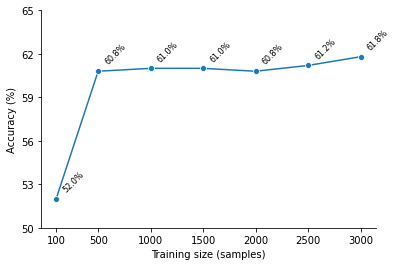

In [34]:
offset = (50,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x = training_sizes
y = [acc*100 for acc in accs_train_size_hmm]
sns.lineplot(x=x, y=y, marker='o', ax=ax)

for i,acc in enumerate(accs_train_size_hmm):
  s = f'{y[i]:.1f}%'

  ax.text(x=x[i]+offset[0], 
          y=y[i]+offset[1],
          rotation=45,
          fontsize=8,
          s=s)

plt.yticks([50 + 3*x for x in range(6)])
plt.ylabel("Accuracy (%)")
plt.xticks(training_sizes)
plt.xlabel("Training size (samples)")

fig.show()

# Part 2: Trees

## **Introduction**
Welcome to **Homework 3 - Trees**! In this part of the homework, we're moving on from HMMs (Part 1) to using trees. We will practice *parsing* on sentences from a semantic parsing corpus.  

The data is obtained from this [paper](https://arxiv.org/pdf/1810.07942.pdf) (see Figure 1). As you can see from the figure, the purpose of this task is to understand what are the users *intents* from a query in plain text.  

The end goal is that given sentence to decode a binary **tree structure** with *semantic tags* as *nodes*. For example:

> whats there to do this weekend -> [<font color='00b8d4'>IN:GET_EVENT</font> whats there to do [<font color='00b8d4'>SL:DATE_TIME</font> this weekend]]  

Note that the brackets [<font color='00b8d4'>LABEL</font> a substring of the text] indicates that this span is a sub-tree and <font color='00b8d4'>LABEL</font>  is the semantic label of the root of the sub-tree. You might read more about bracket representation in this [tutorial](https://www.tutorialspoint.com/binary-tree-to-string-with-brackets-in-cplusplus). 

1. In **Part A**, we formulate this problem as a simple classification problem --- the input to the classifier will be `(text, span)` and the output will be the semantic `label` of that span. `span`  is represented by two integer `(i,j)` which are the start and the end locations of the span.

2. In **Part B**, we will implement a **CKY**-style decoding algorithm to decode the final tree based on the classifier we trained in Part A.

We did pre-processing to enable CKY-style decoding for you. This includes binarization of the trees and handling of unary rules. (see the [code](https://github.mit.edu/tianxing/mit_6864_hw3_202003)).  

Let's start by loading some dependencies and downloading the data as usual.

In [3]:
if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

## **Agenda**

We apply a model that learns the parsing structures in 4 steps.

1. Enumerating all possible spans of a sentence
2. Generating word and span embeddings
3. Learning span label classifications
4. Decoding a tree structure using the classification distributions of spans

We go through this process step by step through the homework

## **PART A**

### **Data Processing**

The very first step of the project is to load the corpus, building the **vocabulary**, **span label set**, and **span indices**. 

We first need to enumerate every node of a tree with a Depth First Search (DFS).

In [4]:
def tree_dfs(node, span_list, label_dict, mode):
    """
    The base function for the recursion:
      node: current root while traversing the tree
      span_list: keep tracks of the spans and their label encodings in the tree e.g [[(0,1), 1], [(0,6),45] ...] 
      label_dict: mapping from label to their encodings e.g {"UNK":0, "Token":1,"None":2, ... }
      mode: "train" or "eval"
    """
  
    if len(node.children) == 0:
        assert(type(node) == Token)
        cur_span = (node.index, node.index + 1)
        cur_label = label_dict['Token']
        span_list.append([cur_span, cur_label])
        return span_list, label_dict
        
    cur_span = node.get_token_span()
    cur_label = node.label

    if node.label in label_dict:
        cur_label = label_dict[node.label]
    
    elif mode == 'train': # we are constructing the label dictionary
        cur_label = len(label_dict)
        label_dict[node.label] = cur_label
    
    else:
        cur_label = label_dict['UNK']
    
    span_list.append([cur_span, cur_label])
    
    # If only has one child, we will ignore the Token label, otherwise the token 
    # span would have two conflicting labels
    if len(node.children) > 1: 
        for child in node.children:
            span_list, label_dict = tree_dfs(child, span_list, label_dict, mode) 

    return span_list, label_dict

Now, we go through the corpus and construct the **vocab dictionary** and the **label dictionary**. Note that we just add new words and labels to the dictionaries while building the training set. Unseen words or labels in validation and test set are marked as unknown (UNK).

In [5]:
def process_line(line, vocab_dict, label_dict, mode):
    '''
    Processing a line in the corpus.
    line format: Sentence \t Sentence_Tree \n
    
    Example:
        'what is the shortest way home\t
        [IN:GET_DIRECTIONS what [SUB is [SUB the [SUB shortest [SUB way [SL:DESTINATION home ] ] ] ] ] ]\n'
    
    Inputs:
    vocab_dict: vocab dictionary {word: word_index, ...}
    labels_dict: label dictionary {label: label_index, ...}
    mode: "train" or "eval"
    '''
    s, s_tree = line.strip().split('\t')
    words = s.split(' ')
    word_ids = []

    for word in words:
        if word in vocab_dict:
            word_ids.append(vocab_dict[word])

        elif mode == 'train':
            word_ids.append(len(vocab_dict))
            vocab_dict[word] = len(vocab_dict)

        else:
            word_ids.append(vocab_dict['UNK'])
    
    tree = Tree(s_tree)
    span_list = []
    span_list, label_dict = tree_dfs(tree.root.children[0], span_list, label_dict, mode)
    
    return word_ids, span_list, vocab_dict, label_dict

def process_corpus(corpus_path, mode, vocab_dict=None, label_dict=None):
    lines = open(corpus_path).readlines()
    if not vocab_dict:
        vocab_dict = {'UNK': 0}
    if not label_dict:
        label_dict = {'UNK': 0, 'Token': 1, 'None': 2}
    corpus = []
    sent_spans = []
    raw_lines = []
    for line in lines:
      if len(line.strip()) < 3: 
        continue
      word_ids, span_list, vocab_dict, label_dict = process_line(line, vocab_dict, label_dict, mode)
      corpus.append(word_ids)
      sent_spans.append(span_list)
      raw_lines.append(line)
    return corpus, sent_spans, vocab_dict, label_dict, raw_lines



In [6]:
corpus_train, spans_train, vocab_dict, label_dict, train_lines = process_corpus('/content/hw3/trees/train.txt', 'train')
corpus_valid, spans_valid, _, _, valid_lines = process_corpus('/content/hw3/trees/valid.txt', 'eval',
                                                 vocab_dict=vocab_dict, label_dict=label_dict)
corpus_test,  spans_test, _, _, test_lines = process_corpus('/content/hw3/trees/test.txt', 'eval',
                                                 vocab_dict=vocab_dict, label_dict=label_dict)

In [7]:
# inverted dictionaries {word_index: word, ...}
inv_vocab_dict = np.array(list(vocab_dict.keys()))
inv_label_dict = np.array(list(label_dict.keys()))

In [8]:
num_words = len(vocab_dict)
num_labels = len(label_dict)

print(f'Number of different words: {num_words}')
print(f'Number of different labels: {num_labels}')

Number of different words: 8626
Number of different labels: 147


Let see how the data looks like, and compare with our output in below:
```
['how', 'long', 'will', 'it', 'take', 'to', 'drive', 'from', 'chicago', 'to', 'mississippi']
how long will it take to drive from chicago to mississippi	[IN:GET_ESTIMATED_DURATION how [SUB long [SUB will [SUB it [SUB take [SUB to [SUB [SL:METHOD_TRAVEL drive ] [SUB from [SUB [SL:SOURCE chicago ] [SUB to [SL:DESTINATION mississippi ] ] ] ] ] ] ] ] ] ] ]

[[(0, 11), 3], [(0, 1), 1], [(1, 11), 4], [(1, 2), 1], [(2, 11), 4], [(2, 3), 1], [(3, 11), 4], [(3, 4), 1], [(4, 11), 4], [(4, 5), 1], [(5, 11), 4], [(5, 6), 1], [(6, 11), 4], [(6, 7), 5], [(7, 11), 4], [(7, 8), 1], [(8, 11), 4], [(8, 9), 6], [(9, 11), 4], [(9, 10), 1], [(10, 11), 7]]
['will', 'it', 'take', 'shorter', 'to', 'get', 'to', 'the', 'white', 'house', 'by', 'bus', 'or', 'taxi', '?']
will it take shorter to get to the white house by bus or taxi ?	[IN:UNSUPPORTED_NAVIGATION will [SUB it [SUB take [SUB shorter [SUB to [SUB get [SUB to [SUB the [SUB white [SUB house [SUB by [SUB bus [SUB or [SUB taxi ? ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 15), 8], [(0, 1), 1], [(1, 15), 4], [(1, 2), 1], [(2, 15), 4], [(2, 3), 1], [(3, 15), 4], [(3, 4), 1], [(4, 15), 4], [(4, 5), 1], [(5, 15), 4], [(5, 6), 1], [(6, 15), 4], [(6, 7), 1], [(7, 15), 4], [(7, 8), 1], [(8, 15), 4], [(8, 9), 1], [(9, 15), 4], [(9, 10), 1], [(10, 15), 4], [(10, 11), 1], [(11, 15), 4], [(11, 12), 1], [(12, 15), 4], [(12, 13), 1], [(13, 15), 4], [(13, 14), 1], [(14, 15), 1]]
['will', 'i', 'make', 'it', 'to', 'the', 'beach', 'by', 'noon', 'if', 'i', 'leave', 'now']
will i make it to the beach by noon if i leave now	[IN:GET_ESTIMATED_ARRIVAL will [SUB i [SUB make [SUB it [SUB to [SUB [SL:DESTINATION--IN:GET_LOCATION--SL:CATEGORY_LOCATION the beach ] [SUB [SL:DATE_TIME_ARRIVAL by noon ] [SUB if [SUB i [SUB leave [SL:DATE_TIME_DEPARTURE now ] ] ] ] ] ] ] ] ] ] ]

[[(0, 13), 9], [(0, 1), 1], [(1, 13), 4], [(1, 2), 1], [(2, 13), 4], [(2, 3), 1], [(3, 13), 4], [(3, 4), 1], [(4, 13), 4], [(4, 5), 1], [(5, 13), 4], [(5, 7), 10], [(5, 6), 1], [(6, 7), 1], [(7, 13), 4], [(7, 9), 11], [(7, 8), 1], [(8, 9), 1], [(9, 13), 4], [(9, 10), 1], [(10, 13), 4], [(10, 11), 1], [(11, 13), 4], [(11, 12), 1], [(12, 13), 12]]
['when', 'should', 'i', 'leave', 'my', 'house', 'to', 'get', 'to', 'the', 'hamilton', 'mall', 'right', 'when', 'it', 'opens', 'on', 'saturday']
when should i leave my house to get to the hamilton mall right when it opens on saturday	[IN:GET_ESTIMATED_DEPARTURE when [SUB should [SUB i [SUB leave [SUB [SL:SOURCE--IN:GET_LOCATION_HOME [SL:CONTACT my ] house ] [SUB to [SUB get [SUB to [SUB [SL:DESTINATION--IN:GET_LOCATION--SL:POINT_ON_MAP the [SUB hamilton mall ] ] [SL:DATE_TIME_ARRIVAL right [SUB when [SUB it [SUB opens [SUB on saturday ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 18), 13], [(0, 1), 1], [(1, 18), 4], [(1, 2), 1], [(2, 18), 4], [(2, 3), 1], [(3, 18), 4], [(3, 4), 1], [(4, 18), 4], [(4, 6), 14], [(4, 5), 15], [(5, 6), 1], [(6, 18), 4], [(6, 7), 1], [(7, 18), 4], [(7, 8), 1], [(8, 18), 4], [(8, 9), 1], [(9, 18), 4], [(9, 12), 16], [(9, 10), 1], [(10, 12), 4], [(10, 11), 1], [(11, 12), 1], [(12, 18), 11], [(12, 13), 1], [(13, 18), 4], [(13, 14), 1], [(14, 18), 4], [(14, 15), 1], [(15, 18), 4], [(15, 16), 1], [(16, 18), 4], [(16, 17), 1], [(17, 18), 1]]
['i', 'need', 'to', 'know', 'if', 'there', "'s", 'a', 'lot', 'of', 'traffic', 'on', 'my', 'way', 'home']
i need to know if there 's a lot of traffic on my way home	[IN:GET_INFO_TRAFFIC i [SUB need [SUB to [SUB know [SUB if [SUB there [SUB 's [SUB a [SUB lot [SUB of [SUB traffic [SUB on [SUB my [SUB way [SL:DESTINATION--IN:GET_LOCATION_HOME home ] ] ] ] ] ] ] ] ] ] ] ] ] ] ]

[[(0, 15), 17], [(0, 1), 1], [(1, 15), 4], [(1, 2), 1], [(2, 15), 4], [(2, 3), 1], [(3, 15), 4], [(3, 4), 1], [(4, 15), 4], [(4, 5), 1], [(5, 15), 4], [(5, 6), 1], [(6, 15), 4], [(6, 7), 1], [(7, 15), 4], [(7, 8), 1], [(8, 15), 4], [(8, 9), 1], [(9, 15), 4], [(9, 10), 1], [(10, 15), 4], [(10, 11), 1], [(11, 15), 4], [(11, 12), 1], [(12, 15), 4], [(12, 13), 1], [(13, 15), 4], [(13, 14), 1], [(14, 15), 18]]
```

In [9]:
for i in range(5):
  print([inv_vocab_dict[w] for w in corpus_train[i]])
  print(train_lines[i], end="")
  print(spans_train[i])
  print()

['how', 'long', 'will', 'it', 'take', 'to', 'drive', 'from', 'chicago', 'to', 'mississippi']
how long will it take to drive from chicago to mississippi	[IN:GET_ESTIMATED_DURATION how [SUB long [SUB will [SUB it [SUB take [SUB to [SUB [SL:METHOD_TRAVEL drive ] [SUB from [SUB [SL:SOURCE chicago ] [SUB to [SL:DESTINATION mississippi ] ] ] ] ] ] ] ] ] ] ]
[[(0, 11), 3], [(0, 1), 1], [(1, 11), 4], [(1, 2), 1], [(2, 11), 4], [(2, 3), 1], [(3, 11), 4], [(3, 4), 1], [(4, 11), 4], [(4, 5), 1], [(5, 11), 4], [(5, 6), 1], [(6, 11), 4], [(6, 7), 5], [(7, 11), 4], [(7, 8), 1], [(8, 11), 4], [(8, 9), 6], [(9, 11), 4], [(9, 10), 1], [(10, 11), 7]]

['will', 'it', 'take', 'shorter', 'to', 'get', 'to', 'the', 'white', 'house', 'by', 'bus', 'or', 'taxi', '?']
will it take shorter to get to the white house by bus or taxi ?	[IN:UNSUPPORTED_NAVIGATION will [SUB it [SUB take [SUB shorter [SUB to [SUB get [SUB to [SUB the [SUB white [SUB house [SUB by [SUB bus [SUB or [SUB taxi ? ] ] ] ] ] ] ] ] ] ] ] ] ] ]


### **Defining the Neural Network**

#### **Sentence Encoding**

We use a Bi-directional LSTM for sentence encoding. We build a sentence encoder with a embedding layer and a Bi-directional LSTM layer:

- Input: 
 - word indices: `[batch_size, sentence_length]`
- Output: 
  - word embeddings: `[batch_size, sentence_length, 2*hidden_size]`

In [28]:
class SentEnc(nn.Module):
    def __init__(self, num_words, num_layers, hidden_size, dropout=0, bidirectional=True):
        super(SentEnc, self).__init__()
    
        self.embedding = nn.Embedding(num_words, hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size, num_layers=num_layers,
                            hidden_size=hidden_size, 
                            bidirectional =bidirectional, dropout = dropout, 
                            batch_first=True)
    
    def forward(self, x):
        '''
        x: [batch_size, sentence_length] matrix of word indices
        This function should return a matrix of 
        [batch_size, sentence_length, 2*hidden_size] word embeddings. 
        '''
        embedded_input = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded_input)

        return outputs

### **Span Encodings**

Given the LSTM outputs, we generate the span embeddings with the span indices.

We generate a span embedding by concatenating the word embeddings of the first and last words of a span. For example, if a span starts from the i-th word and ends at the j-th word, our span embedding would be

$$[h_i^T; h_{j-1}^T]^T$$

where $h_i$ stands for the Bi-LSTM output of the $i^{th}$ word. Note that span_ij is inclusive to i but exclusive to j, as would be the output if you sliced a Python list A[i:j]. 


In Pytorch, Given the hidden states $h[0], h[1], ..., h[n]$, where
```
h[i].size() = [1, k]
```
the embedding of span (i, j) is
```
span_ij = torch.cat([h[i], h[j-1]], dim=1)
span_ij.size() = [1, 2 * k]
```
Please complete the following function for generating span embeddings.

- Input: 
 - word embeddings: `[sentence_length, hidden_size]` 
 - span indices: `[num_span, 2]`
- Output: 
 - span embeddings `[num_span, hidden_size * 2]`



In [11]:
def get_span_embeddings(word_embeddings, span_indices):
  '''
  word_embeddings: [sentence_length, hidden_size] matrix of each word's' embeddings from the sentence
  span_indices: [num_span, 2] matrix of all span indices
  '''
  num_span = span_indices.shape[0]
  hidden_size = word_embeddings.shape[1]

  span_embeddings = torch.zeros(num_span, 2*hidden_size, device=device)

  for row, (i,j) in enumerate(span_indices):
    span_embedding = torch.cat([word_embeddings[i,:], word_embeddings[j-1,:]])
    span_embeddings[row,:] = span_embedding

  return span_embeddings

### **Tag Prediction**

We build a Classifier that puts the neural models together. The classifier takes word and span indices as inputs, and predict span labels by calculating word embeddings, span embeddings, and label logits. we will predict the tag of the spans with a linear classifier.

- Inputs: 
 - word indices: `[batch_size, num_words]`
- Outputs: 
 - span predictions: `[num_spans, num_labels]`

Please implement the forward function following 4 steps:
1. Generate the word embeddings by processing the input sentences with the LSTM sentence encoder.
2. Apply dropout on word embeddings.
3. Calculate span embeddings with function get_span_embeddings().
4. Calculate label logits with the linear layer defined as follows.


In [36]:
class Classifier(nn.Module):
    
    def __init__(self, num_words, num_labels, num_layers, hidden_size, 
                 dropout={'classifier':0, 'lstm':0}, bidirectional=True):
        super(Classifier, self).__init__()
        self.sent_enc = SentEnc(num_words, num_layers, hidden_size, 
                                dropout = dropout['lstm'], bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout['classifier'])
        self.linear = nn.Linear((2 + 2*bidirectional) * hidden_size, num_labels)
    
    def forward(self, x, span_indices):
      '''
      x: [batch_size, num_words] matrix of the word indices
      span_indices: [num_spans, 2] matrix of the span indices
      This function should return a matrix of [num_spans, num_labels] where
      each row contains the label logits corresponding to the relevant span.
      You can assume batch_size is 1. 
      '''
      # Step 1
      embedded_sent = self.sent_enc(x)[0,:,:]

      # Step 2
      embedded_sent_drop = self.dropout(embedded_sent)

      # Step 3
      span_embeddings = get_span_embeddings(embedded_sent_drop, span_indices)

      # Step 4
      logits = self.linear(span_embeddings)

      return logits

In [13]:
# For decoding, we add some random spans and label them as "None"
def add_none_span(word_list, span_list, label_dict, all=False):
    num_words = len(word_list)
    num_labeled_span = len(span_list)
    labeled_span_set = set([span for span, label in span_list])
    none_spans = []

    for i in range(num_words):
        for j in range(i + 1, num_words):
            if (i, j) not in labeled_span_set:
                none_spans.append([(i, j), label_dict['None']])

    if not all:
        k = min(num_labeled_span, len(none_spans))
        sampled_none_spans = random.sample(none_spans, k)

    else:
        sampled_none_spans = none_spans
        
    return span_list + sampled_none_spans

### Training

#### Training function

In [30]:
def training_tree_classifier(train_data, val_data, num_epochs=3, 
                             num_layers=1, hidden_size=200, lr=0.05, 
                             dropout={'classifier':0.25, 'lstm' : 0}, 
                             bidirectional = True, verbose=True):
  # Loss function
  loss_fn = nn.CrossEntropyLoss().to(device)

  # Initialize classifier and optimizer
  classifier = Classifier(num_words, num_labels, num_layers, hidden_size, 
                          dropout, bidirectional)
  classifier = classifier.to(device)
  classifier.train()

  optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.9)

  # Training loop
  for epoch in range(num_epochs):
      total_loss = 0
      classifier.train()

      for i in tqdm(range(len(corpus_train))):

        cur_spans = add_none_span(corpus_train[i], spans_train[i], label_dict)
        
        sent_inputs  = torch.Tensor([corpus_train[i]]).long().to(device)
        span_indices = torch.Tensor([x[0] for x in cur_spans]).long().to(device)
        span_labels  = torch.Tensor([x[1] for x in cur_spans]).long().to(device)
        
        # Obtain predictions from classifier
        preds = classifier(sent_inputs, span_indices)

        # Compute loss
        loss = loss_fn(preds, span_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update total_loss
        total_loss += loss.item()
        
      if verbose:
        print(f'Epoch {epoch+1}, train loss = {total_loss / (1. * len(corpus_train)):.4f}')

      total_loss = 0

      classifier.eval()

      for i in tqdm(range(len(corpus_valid))):
        cur_spans = add_none_span(corpus_valid[i], spans_valid[i], label_dict)
        
        sent_inputs  = torch.Tensor([corpus_valid[i]]).long().to(device)
        span_indices = torch.Tensor([x[0] for x in cur_spans]).long().to(device)
        span_labels  = torch.Tensor([x[1] for x in cur_spans]).long().to(device)
        
        with torch.no_grad():
          # Obtain predictions from classifier
          preds = classifier(sent_inputs, span_indices)

          # Compute loss
          loss = loss_fn(preds, span_labels)

          # Update total_loss
          total_loss += loss.item()
      
      if verbose:
        print(f'Epoch {epoch+1}, validation loss = {total_loss / (1. * len(corpus_train)):.4f}')
        print("")
  
  return classifier

#### Training execution

In [38]:
print('Using device: {}'.format(device))

# Set seed for reproducibility
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Parameters
params = {'num_epochs'    : 3,
          'num_layers'    : 3,
          'hidden_size'   : 400,
          'lr'            : 0.05,
          'dropout'       : {'classifier' : 0.25, 'lstm': 0.25},
          'bidirectional' : True,
          'verbose'       : True
}

# Run training loop
classifier = training_tree_classifier(corpus_train, corpus_valid, **params)

Using device: cuda


  0%|          | 0/31279 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Evaluation

#### Calculator class

In [16]:
class Calculator:
    def __init__(self, strict = False) -> None:
        self.TP = 0
        self.gold_P = 0
        self.pred_P = 0      
        self.exact_match = []
        self.tree_match = []
        self.well_form = []
        self.strict = strict

    def get_metrics(self):
        precision = (self.TP / self.pred_P) if self.pred_P else 0
        recall = (self.TP / self.gold_P) if self.gold_P else 0
        f1 = (2.0 * precision * recall / (precision + recall)) if (precision + recall) else 0
     
        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "exact_match": np.mean(self.exact_match),
            "well_form": np.mean(self.well_form),
            "tree_match":  np.mean(self.tree_match),
            "num_examples": len(self.exact_match)
        }
    
    def is_well_formed(self, spans):   
        for s1 in spans: 
          for s2 in spans:
              if s1[0] < s2[0] and s2[0] < s1[1] and s1[1] < s2[1]:
                    return False
        return True

    def add_instance_span(self, gold_spans, pred_spans):
        self.gold_P += len(gold_spans)
        self.pred_P += len(pred_spans)
        self.TP += len(set(gold_spans) & set(pred_spans))
        self.exact_match.append(int(set(gold_spans) == set(pred_spans)))
        gold_spans = [s[0] for s in gold_spans]
        pred_spans = [s[0] for s in pred_spans]
        self.tree_match.append(int(set(gold_spans) == set(pred_spans)))
        well_formed = self.is_well_formed(pred_spans)
        self.well_form.append(int(well_formed))

    def add_instance_tree(self, gold_tree, pred_tree):
        node_info_gold = self._get_node_info(gold_tree)
        self.gold_P += len(node_info_gold)
        node_info_pred = self._get_node_info(pred_tree)
        self.pred_P += len(node_info_pred)
        self.TP += len(node_info_gold & node_info_pred)
        self.exact_match.append(int(node_info_gold.keys() == node_info_pred.keys()))
        self.well_form.append(1) #we assume the decoded tree is indeed a tree :)
        node_info_gold = {k[1] for k,v in node_info_gold.items()}
        node_info_pred = {k[1] for k,v in node_info_pred.items()}
        self.tree_match.append(int(node_info_gold==node_info_pred))
        
    def _get_node_info(self, tree):
        nodes = tree.root.list_nonterminals()
        node_info: Counter = Counter()
        for node in nodes:
            if node.label != 'Token':
              span = self._get_span(node)
              node_info[(node.label, self._get_span(node))] += 1 

        return node_info

    def _get_span(self, node):
        return node.get_flat_str_spans(
        ) if self.strict else node.get_token_span()

#### Obtain metrics

In [22]:
classifier.eval()
parta_calc = Calculator(strict=False)
pred_bag_spans = []
gold_bag_spans = []
for (tokens, spans, line) in zip(corpus_test,spans_test,test_lines):   
    # We only test non-Token labels
    spans = [tuple(x) for x in spans if x[1] != 1]

    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue

    all_spans = [(i,j) for i in range(len(tokens)) 
                        for j in range(i + 1, len(tokens) + 1)]

    input  = torch.Tensor([tokens]).long().to(device)
    logits = classifier(input, torch.Tensor(all_spans).long().to(device))

    pred_spans = []
    for i, span in enumerate(all_spans):
        label_idx = torch.argmax(logits[i]).item()
        if label_idx != 2 and label_idx != 1:
          pred_spans.append((span,label_idx))
    
    parta_calc.add_instance_span(spans, pred_spans)
    pred_bag_spans.append(pred_spans)
    gold_bag_spans.append(spans)

parta_metrics = parta_calc.get_metrics()

#### Show metrics
After training the model, we evaluate the classification results.  
What we will do is that we treat a tree strcture as a bag of spans (a list of span indices), and then compute F-1 score.  
The staff solution computed precision near 0.85, recall near 0.94, f1 near 0.89, and exact_match near 0.42.

In [23]:
for key in parta_metrics:
  if key.find("_") != -1:
    name = key.replace('_', " ").title()
  else:
    name = key.title()
  
  value = parta_metrics[key]

  if type(value) == int:
    print(f'{name} = {parta_metrics[key]:d}')
  else:
    print(f'{name} = {parta_metrics[key]:.3f}')

Precision = 0.848
Recall = 0.945
F1 = 0.894
Exact Match = 0.416
Well Form = 0.542
Tree Match = 0.479
Num Examples = 8997


### Experiments for part A

#### Part (a)

In [37]:
print('Using device: {}'.format(device))

# Set seed for reproducibility
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Parameters
params = {'num_epochs'    : 3,
          'num_layers'    : 2,
          'hidden_size'   : 200,
          'lr'            : 0.05,
          'dropout'       : {'classifier' : 0.25, 'lstm': 0},
          'bidirectional' : False,
          'verbose'       : True
}

# Run training loop
classifier = training_tree_classifier(corpus_train, corpus_valid, **params)

Using device: cuda


  0%|          | 0/31279 [00:00<?, ?it/s]

Epoch 1, train loss = 0.4940


  0%|          | 0/4462 [00:00<?, ?it/s]

Epoch 1, validation loss = 0.0508



  0%|          | 0/31279 [00:00<?, ?it/s]

Epoch 2, train loss = 0.3541


  0%|          | 0/4462 [00:00<?, ?it/s]

Epoch 2, validation loss = 0.0461



  0%|          | 0/31279 [00:00<?, ?it/s]

Epoch 3, train loss = 0.3095


  0%|          | 0/4462 [00:00<?, ?it/s]

Epoch 3, validation loss = 0.0464



#### Obtain metrics

In [ ]:
classifier.eval()
parta2_calc = Calculator(strict=False)
pred_bag_spans = []
gold_bag_spans = []

for (tokens, spans, line) in zip(corpus_test,spans_test,test_lines):   
    # We only test non-Token labels
    spans = [tuple(x) for x in spans if x[1] != 1]

    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue

    all_spans = [(i,j) for i in range(len(tokens)) 
                        for j in range(i + 1, len(tokens) + 1)]

    input  = torch.Tensor([tokens]).long().to(device)
    logits = classifier(input, torch.Tensor(all_spans).long().to(device))

    pred_spans = []
    for i, span in enumerate(all_spans):
        label_idx = torch.argmax(logits[i]).item()
        if label_idx != 2 and label_idx != 1:
          pred_spans.append((span,label_idx))
    
    parta_calc.add_instance_span(spans, pred_spans)
    pred_bag_spans.append(pred_spans)
    gold_bag_spans.append(spans)

parta2_metrics = parta_calc.get_metrics()

#### Show metrics

In [ ]:
for key in parta_metrics:
  if key.find("_") != -1:
    name = key.replace('_', " ").title()
  else:
    name = key.title()
  
  value = parta_metrics[key]

  if type(value) == int:
    print(f'{name} = {parta2_metrics[key]:d}')
  else:
    print(f'{name} = {parta2_metrics[key]:.3f}')

Precision = 0.848
Recall = 0.945
F1 = 0.894
Exact Match = 0.416
Well Form = 0.542
Tree Match = 0.479
Num Examples = 8997


## **PART B** (Only for 6.864 students)
The remaining will be **Part B** for **HW3-Trees**.  
In Part B, we will decode a tree based on the classifier trained on Part A.  


### **CKY**  
You will be implementing the following simple CKY recursion:  
```best_score[i,j]=max_k {best_score[i,k]+best_score[k,j]} + max_l {span_dict[(i,j)][l]}```      
where `l` is the label of the current span `(i,j)`, and `k` is the splitting point. `k` is inclusive to the right span. 

Note that this is a simpler recursion than the full CKY algorithm.

In [28]:
EPS = 1e-6
dp_results = []
classifier.eval()

for kk, (line,spans,tokens) in enumerate(zip(test_lines,spans_test,corpus_test)):
    spans = [tuple(x) for x in spans if  x[1] != 1]
    
    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue
    
    sent_inputs  = torch.Tensor([tokens]).long().to(device)
    
    all_spans = [(i,j) for i in range(len(tokens)) 
                         for j in range(i + 1, len(tokens) + 1)]
    
    logits = classifier(sent_inputs, torch.Tensor(all_spans).long().to(device))
    logprobs = log_softmax(logits, dim = -1)

    # span dict will map each span (l,r) to its predicted distribution of labels
    span_dict = {}
    
    for i, s in enumerate(all_spans): 
      span_dict[s]  = logprobs[i] 
  
    TOKEN_ID, NULL_ID = 1, 2
    best_score, best_split, best_label = {}, {}, {}
    
    # we will do dynamic programming to decode a binary tree out of our predictions
    # Think: why do we first iterate the length of the span?
    for ll in range(1, len(tokens) + 1): # length of the span
        for i in range(0, len(tokens)-ll+1): # start of the span
            j = i + ll
            cur_span = (i, j)
            
            if j == i + 1:
                span_dict[cur_span][NULL_ID]  = -1/EPS
                # --------- Your code --------- #
                #use span_dict[cur_span] to update best_label and best_score              

                
                # --------- Your code ends --------- #
                best_split[cur_span] = None
            
            else:
                span_dict[cur_span][NULL_ID]  = -1/EPS # we will never decode a NULL sub-tree
                span_dict[cur_span][TOKEN_ID] = -1/EPS # we will never decode a NULL sub-tree
                # --------- Your code --------- #
                #try to give the values for best_score/label/split[cur_span] using the 
                # recursive equation above



                # --------- Your code ends --------- #
            #print(cur_span, best_score[cur_span], best_label[cur_span])
    dp_results.append((best_score, best_split, best_label))
print(len(dp_results))

KeyboardInterrupt: ignored

### **Tree Construction**
In this section, we will construct a tree using the DP results.  
The code relies on a `Node` class defined in `span_tree.py`. Each `Node` object has `children`, `parent`, and `label` attributes, where `children` is a `List`, `parent` is an optional `Node`, and `label` is a `str`. 

You won't need more than this to fill out the code, but feel free to look more into `span_tree.py` for a better understanding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
def get_nodetype(label):
    if label.startswith(PREFIX_INTENT):
        node = Intent(label)
    elif label.startswith(PREFIX_SLOT):
        node = Slot(label)
    elif label.startswith(PREFIX_SUBTREE):
        node = SubTree(label)
    else:
        print('something wrong with the label!!!', label)
        sys.error()
    return node

def dfs_build(l, r, best_label, best_split):
  '''
  l: integer representing left (inclusive) index of span
  r: integer representing right (non-inclusive) index of span
  best_label: {span: label_index} dictionary created in dp_results
  best_split: {span: split} dictionary created in dp_results
  This function returns the node for the given span, recursively 
  creating all children nodes below it. 
  '''
    if l + 1 == r:
        la = best_label[(l,r)]
        if la == 1:
            return Token(surface_tokens[l], l)
        else:
            node = get_nodetype(inv_label_dict[la])
            node.children = [Token(surface_tokens[l], l)]
            node.children[0].parent = node
            return node

    label = inv_label_dict[best_label[(l, r)]]
    node = get_nodetype(label)
    
    #--- your code --- #
    #hint: use best_split! and recursion to assign node.children here


    #--- your code ends --- #

    for c in node.children:
        c.parent = node
    
    return node


In [ ]:
pred_trees = []
gold_trees = []
partb_calc = Calculator(strict=False)
k = 0
for i,(line,spans,tokens) in enumerate(zip(test_lines,spans_test,corpus_test)):
    surface_tokens, str_ref_tree = line.strip().split('\t')
    surface_tokens = surface_tokens.split()
    spans = [tuple(x) for x in spans if x[1] != 1]

    if len(spans) <= 1 or len(line.strip()) < 3: 
      continue

    best_score, best_split, best_label = dp_results[k]
    k+=1
    root = Root()
    root.children = [dfs_build(0, len(tokens), best_label, best_split)]
    root.children[0].parent = root
    tree = Tree('IN:GET_EVENT placeholder') #the string here is just a placeholder
    tree.root = root
    if k < 10: #use this info for debugging! Does your tree make sense?
        print(k, line.strip())
        print('REF:', str_ref_tree)
        print('DEC:', str(tree))
        print()
    """ here's some decoding examples we get
      1 whats there to do this weekend	[IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]
      REF: [IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]
      DEC: [IN:GET_EVENT whats [SUB there [SUB to [SUB do [SL:DATE_TIME this weekend ] ] ] ] ]

      2 what is a good restaurant for tex mex in austin	[IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]
      REF: [IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]
      DEC: [IN:UNSUPPORTED what [SUB is [SUB a [SUB good [SUB restaurant [SUB for [SUB tex [SUB mex [SUB in austin ] ] ] ] ] ] ] ] ]

      3 where can i see the fireworks tonight	[IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB [SL:CATEGORY_EVENT the fireworks ] [SL:DATE_TIME tonight ] ] ] ] ] ]
      REF: [IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB [SL:CATEGORY_EVENT the fireworks ] [SL:DATE_TIME tonight ] ] ] ] ] ]
      DEC: [IN:GET_EVENT where [SUB can [SUB i [SUB see [SUB the [SUB fireworks [SL:DATE_TIME tonight ] ] ] ] ] ] ]
    """
    partb_calc.add_instance_tree(Tree(str_ref_tree), tree)
    pred_trees.append(tree)
    gold_trees.append(Tree(str_ref_tree))

Once again, we'll look at the metrics. 
The staff solution computed precision near 0.87, recall near 0.86, f1 near 0.87, and exact_match near 0.44. 

In [ ]:
print(partb_calc.get_metrics())


Recommended Reading (not required, just for interested students):  
https://arxiv.org/pdf/1810.07942.pdf  
https://www.aclweb.org/anthology/D16-1257/  
https://arxiv.org/abs/1412.7449  